# **Assignment 4**

The complete code and training process can be found in Appendix.

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class Test(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.linear = objax.nn.Linear(32, 10)
    self.linear_2 = objax.nn.Linear(10, 20)

  def __call__(self, x):
   
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    x = self.linear_2(x)
    return x

In [ ]:
modelTest = Test()

In [ ]:
modelTest.vars()

{'(Test).linear(Linear).b': <objax.variable.TrainVar at 0x7f572c711e10>,
 '(Test).linear(Linear).w': <objax.variable.TrainVar at 0x7f577e033208>,
 '(Test).linear_2(Linear).b': <objax.variable.TrainVar at 0x7f57110f5908>,
 '(Test).linear_2(Linear).w': <objax.variable.TrainVar at 0x7f5711117a90>}

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu]) 
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # size=2, strides=2,
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



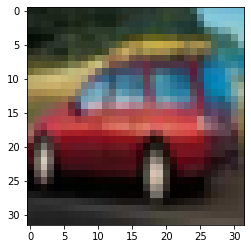

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)
#numpy.expand_dims(a, axis): Insert a new axis that will appear at the axis position in the expanded array shape.

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now
Objax_output = Conv2d(my_image)

print("Filter weights:", filter_weights) 
print("Conv output:", Objax_output)
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[-0.18812537 -0.8232984 ]
   [ 0.66737735 -0.09427553]
   [-0.77696747  0.04807181]]]]
Conv output: [[[[-0.00677497 -0.00560745  0.00094201 ... -0.25968766 -0.24485691
    -0.23497838]
   [-0.01845009 -0.01522969 -0.0107331  ... -0.24791126 -0.23624925
    -0.23508172]
   [-0.01961761 -0.01261253 -0.01657067 ... -0.22570479 -0.21939889
    -0.22808406]
   ...
   [-0.05137052 -0.04903549 -0.04903549 ... -0.04883828 -0.05000579
    -0.05350833]
   [-0.04319793 -0.04086291 -0.04086291 ... -0.05584334 -0.05467583
    -0.05467583]
   [-0.03852789 -0.03736038 -0.03852789 ... -0.07218852 -0.07102101
    -0.06751847]]

  [[-0.08174573 -0.07833593 -0.06829499 ... -0.4095669  -0.4004539
    -0.39779085]
   [-0.11584385 -0.09842508 -0.10239312 ... -0.45431548 -0.4421477
    -0.4387379 ]
   [-0.11925366 -0.0987948  -0.11944217 ... -0.499086   -0.48331258
    -0.47232908]
   ...
   [-0.15003175 -0.14321211 -0.14321211 ... -0.2351618  -0.23857161
    -0.24880105]
   [-0.12616305 -

### **1.**

The size of training dataset = 60,000 * 0.8 = 48,000

Batch size = 32

The number of iterations that will used to go through the entire training set: 48,000/32 = 1,500

The number of iterations are there in 30 epochs: 30 * 1,500 = 45,000


### **2.**

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  image_temp = my_image[0][:].transpose(1,2,0)# 3,32,32 -> 32,32, 3
  weight_temp = initial_filter_weights[0][0].transpose() #3,2 ->2,3
  k_size = 1
  out_channel = 2

  image_shape = my_image.shape[2]
  my_conv_output = np.zeros((image_shape- k_size + 1,image_shape - k_size + 1,out_channel))

  for i in range(image_shape- k_size + 1):
    for j in range(image_shape - k_size + 1):
      temp_a = np.dot(weight_temp,image_temp[i][j])#weight * each pixel
      my_conv_output[i,j] = temp_a
 
 
  my_conv_output = my_conv_output.transpose(2,0,1)
  my_conv_output = np.expand_dims(my_conv_output, 0)

  return my_conv_output

In [ ]:
my_conv_output = my_conv_net(my_image,filter_weights)

In [ ]:
print("my_conv_output :", my_conv_output)
print("my_conv_output shape:", np.shape(my_conv_output))

my_conv_output : [[[[-0.00677497 -0.00560746  0.00094201 ... -0.25968764 -0.24485691
    -0.23497837]
   [-0.01845009 -0.0152297  -0.01073311 ... -0.24791126 -0.23624924
    -0.23508173]
   [-0.0196176  -0.01261253 -0.01657067 ... -0.22570478 -0.21939888
    -0.22808407]
   ...
   [-0.05137052 -0.04903549 -0.04903549 ... -0.04883828 -0.05000579
    -0.05350832]
   [-0.04319793 -0.04086291 -0.04086291 ... -0.05584335 -0.05467583
    -0.05467583]
   [-0.03852789 -0.03736037 -0.03852789 ... -0.07218851 -0.071021
    -0.06751846]]

  [[-0.08174573 -0.07833591 -0.06829499 ... -0.4095669  -0.40045391
    -0.39779084]
   [-0.11584385 -0.09842508 -0.10239312 ... -0.45431545 -0.4421477
    -0.43873789]
   [-0.11925366 -0.09879479 -0.11944218 ... -0.49908597 -0.48331257
    -0.47232907]
   ...
   [-0.15003174 -0.14321211 -0.14321211 ... -0.23516178 -0.2385716
    -0.24880103]
   [-0.12616305 -0.11934343 -0.11934343 ... -0.25562066 -0.25221084
    -0.25221084]
   [-0.1125238  -0.10911399 -0.11252

So my custom convolution filter returns the same output as Objax’s own convolution routine

### **3**

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.08111153, -0.29123962]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#PUT YOUR CODE HERE
Linear_Layer = objax.nn.Linear(2, 1)
w_linear = Linear_Layer.w.value
b_linear = Linear_Layer.b.value
my_conv_output_mean = my_conv_output.mean((2,3))
Y = Linear_Layer(my_conv_output_mean)

print('Output of bjax own linear layer = ', Y)

#manually implements the linear layer
my_linear_result = b_linear + np.dot(my_conv_output_mean,w_linear)

print('Output of my linear layer = ',my_linear_result)



Output of bjax own linear layer =  [[0.30047482]]
Output of my linear layer =  [[0.30047482]]


So my custom linear layer provides the same value as Objax's own linear layer.

You have now completed Part 1 of the assignment. Good job!


## **Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.28 Training Accuracy 9.99 Validation Accuracy 10.32
Epoch 0002  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 10.87 Validation Accuracy 11.78
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 11.94 Validation Accuracy 12.37
Epoch 0004  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 12.64 Validation Accuracy 13.67
Epoch 0005  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 13.59 Validation Accuracy 13.57
Epoch 0006  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 14.17 Validation Accuracy 14.60
Epoch 0007  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 15.05 Validation Accuracy 14.90
Epoch 0008  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 16.07 Validation Accuracy 16.87
Epoch 0009  Training Loss 2.20 Validation Loss 2.20 Training Accuracy 17.02 Validation Accuracy 18.23
Epoch 0010  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 18.05 Validat

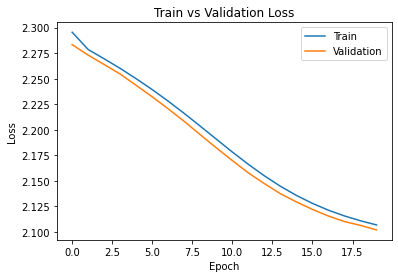

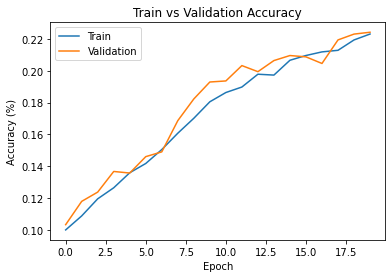

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

### **5.**

H = { learning rate, number of epochs, batch size, size of the convolution kernel }

$H_{1}$ = { 0.001 , 20, 64, 2 } 

$H_{2}$ = { 5e-3, 20, 32, 4} 

### **6.**

Use set $H_{1}$ = { 0.001 , 20, 64, 2 } 

In [ ]:
model = ConvNet()

Epoch 0001  Training Loss 2.33 Validation Loss 2.31 Training Accuracy 10.11 Validation Accuracy 9.92
Epoch 0002  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.69 Validation Accuracy 11.85
Epoch 0003  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 13.42 Validation Accuracy 14.83
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.39 Validation Accuracy 16.22
Epoch 0005  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.43 Validation Accuracy 16.92
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.51 Validation Accuracy 16.80
Epoch 0007  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.31 Validation Accuracy 16.82
Epoch 0008  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 16.35 Validation Accuracy 16.93
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 16.50 Validation Accuracy 16.97
Epoch 0010  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 16.58 Validat

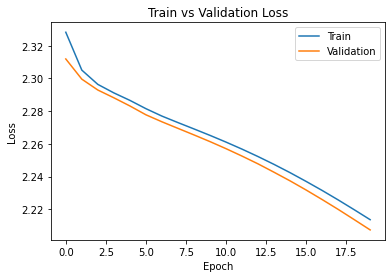

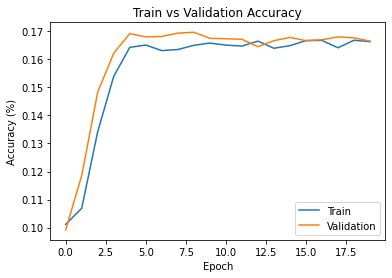

In [ ]:
train(EPOCHS = 20, BATCH = 64, LEARNING_RATE = 0.001)

Use set $H_{2}$ = { 5e-3, 20, 32, 4} 


In [ ]:
class ConvNet_M2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 4), objax.functional.relu]) 
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # size=2, strides=2,
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x


In [ ]:
model = ConvNet_M2()

Epoch 0001  Training Loss 2.27 Validation Loss 2.22 Training Accuracy 16.46 Validation Accuracy 18.97
Epoch 0002  Training Loss 2.15 Validation Loss 2.10 Training Accuracy 20.64 Validation Accuracy 21.90
Epoch 0003  Training Loss 2.09 Validation Loss 2.07 Training Accuracy 22.97 Validation Accuracy 23.80
Epoch 0004  Training Loss 2.06 Validation Loss 2.04 Training Accuracy 24.91 Validation Accuracy 23.75
Epoch 0005  Training Loss 2.03 Validation Loss 2.01 Training Accuracy 26.77 Validation Accuracy 26.37
Epoch 0006  Training Loss 1.99 Validation Loss 1.97 Training Accuracy 28.68 Validation Accuracy 29.35
Epoch 0007  Training Loss 1.96 Validation Loss 1.94 Training Accuracy 30.34 Validation Accuracy 29.72
Epoch 0008  Training Loss 1.92 Validation Loss 1.90 Training Accuracy 31.44 Validation Accuracy 31.27
Epoch 0009  Training Loss 1.89 Validation Loss 1.89 Training Accuracy 33.02 Validation Accuracy 29.92
Epoch 0010  Training Loss 1.86 Validation Loss 1.84 Training Accuracy 33.80 Valida

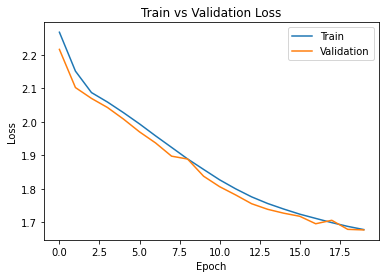

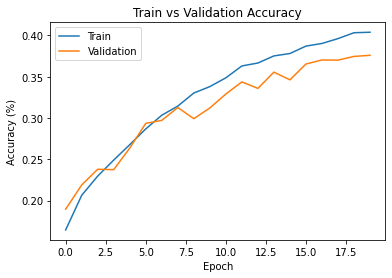

In [ ]:
train(EPOCHS = 20,BATCH = 32,LEARNING_RATE = 5e-3)

### **7.**

I will pick $M_{2}$. Reason:


1.   It has much higher accuracy. The train and validation accuracy of $M_{1}$ stop to increase since epoch 9
2.   It has lower loss. 



In [ ]:
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]

In [ ]:
print('Final Test accuracy = ',test_acc*100,'%')

Final Test accuracy =  37.86666666666667 %


You have now completed Part 2 of the assignment. Good job!


## **Part 3. Trying Out a New Dataset**

See the handout for instructions.


Pick the Fashion-MNIST dataset.

### **1.**

In [ ]:
(X_train_FM, Y_train_FM), (X_test_FM, Y_test_FM) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_FM = X_train_FM/ 255.0
Y_train_FM = Y_train_FM.flatten()
X_test_FM = X_test_FM/ 255.0
Y_test_FM = Y_test_FM.flatten()
np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train_FM, X_test_FM], axis = 0)
Y_data = np.concatenate([Y_train_FM, Y_test_FM], axis = 0)

In [ ]:
X_data = np.expand_dims(X_data, 1)

In [ ]:


N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

### **2.**

In [ ]:
class ConvNet_FM(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 14, 2), objax.functional.relu]) 
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(14, 28, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(28, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # size=2, strides=2,
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

In [ ]:
model = ConvNet_FM()

Epoch 0001  Training Loss 2.31 Validation Loss 2.29 Training Accuracy 9.61 Validation Accuracy 10.21
Epoch 0002  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 9.95 Validation Accuracy 9.99
Epoch 0003  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 10.19 Validation Accuracy 10.10
Epoch 0004  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 10.83 Validation Accuracy 11.20
Epoch 0005  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 13.12 Validation Accuracy 14.91
Epoch 0006  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 14.66 Validation Accuracy 14.40
Epoch 0007  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 16.21 Validation Accuracy 15.97
Epoch 0008  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 17.08 Validation Accuracy 17.90
Epoch 0009  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 18.19 Validation Accuracy 19.87
Epoch 0010  Training Loss 2.18 Validation Loss 2.17 Training Accuracy 19.44 Validatio

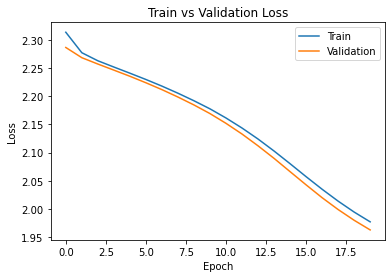

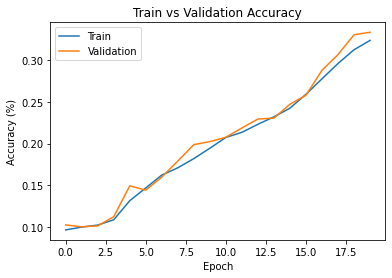

In [ ]:
train()

**hyperparameters set 1**

In [ ]:
model = ConvNet_FM()

Epoch 0001  Training Loss 2.25 Validation Loss 2.22 Training Accuracy 12.50 Validation Accuracy 15.04
Epoch 0002  Training Loss 2.19 Validation Loss 2.15 Training Accuracy 18.88 Validation Accuracy 19.29
Epoch 0003  Training Loss 2.10 Validation Loss 2.05 Training Accuracy 23.36 Validation Accuracy 22.54
Epoch 0004  Training Loss 2.01 Validation Loss 1.96 Training Accuracy 30.48 Validation Accuracy 33.76
Epoch 0005  Training Loss 1.94 Validation Loss 1.90 Training Accuracy 35.19 Validation Accuracy 37.36
Epoch 0006  Training Loss 1.88 Validation Loss 1.84 Training Accuracy 39.06 Validation Accuracy 40.66
Epoch 0007  Training Loss 1.81 Validation Loss 1.77 Training Accuracy 42.03 Validation Accuracy 42.03
Epoch 0008  Training Loss 1.74 Validation Loss 1.69 Training Accuracy 44.39 Validation Accuracy 42.93
Epoch 0009  Training Loss 1.65 Validation Loss 1.61 Training Accuracy 45.75 Validation Accuracy 44.24
Epoch 0010  Training Loss 1.57 Validation Loss 1.54 Training Accuracy 47.12 Valida

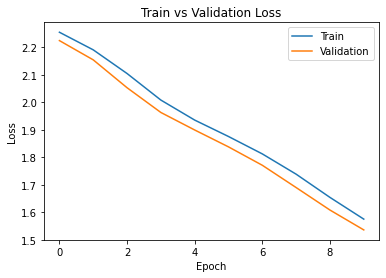

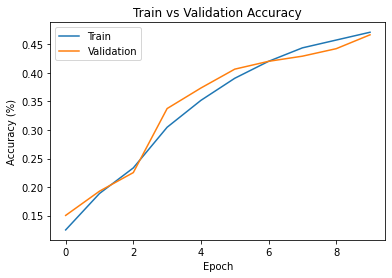

In [ ]:
train(EPOCHS = 10,BATCH = 32,LEARNING_RATE = 5e-3)

**hyperparameters set 2**

In [ ]:
model = ConvNet_FM()

Epoch 0001  Training Loss 2.28 Validation Loss 2.26 Training Accuracy 10.19 Validation Accuracy 10.14
Epoch 0002  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 10.48 Validation Accuracy 10.90
Epoch 0003  Training Loss 2.21 Validation Loss 2.19 Training Accuracy 12.44 Validation Accuracy 15.37
Epoch 0004  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 18.91 Validation Accuracy 22.91
Epoch 0005  Training Loss 2.11 Validation Loss 2.07 Training Accuracy 24.67 Validation Accuracy 26.91
Epoch 0006  Training Loss 2.05 Validation Loss 2.02 Training Accuracy 27.46 Validation Accuracy 25.74
Epoch 0007  Training Loss 2.00 Validation Loss 1.97 Training Accuracy 28.52 Validation Accuracy 29.96
Epoch 0008  Training Loss 1.96 Validation Loss 1.93 Training Accuracy 31.64 Validation Accuracy 30.51
Epoch 0009  Training Loss 1.93 Validation Loss 1.90 Training Accuracy 33.11 Validation Accuracy 33.83
Epoch 0010  Training Loss 1.90 Validation Loss 1.88 Training Accuracy 35.07 Valida

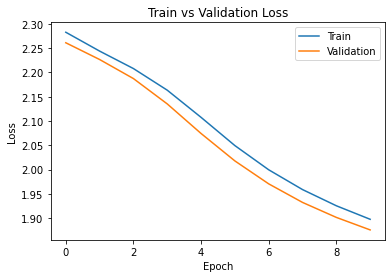

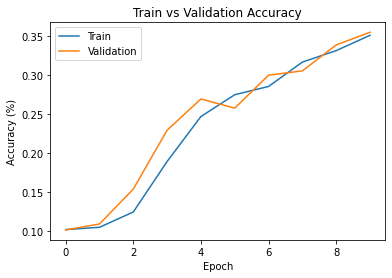

In [ ]:
train(EPOCHS = 10,BATCH = 64,LEARNING_RATE = 5e-3)

**hyperparameters set 3**

In [ ]:
model = ConvNet_FM()

Epoch 0001  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.63 Validation Accuracy 9.69
Epoch 0002  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 10.24 Validation Accuracy 10.41
Epoch 0003  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 11.83 Validation Accuracy 13.07
Epoch 0004  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 14.34 Validation Accuracy 15.04
Epoch 0005  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 15.95 Validation Accuracy 16.49
Epoch 0006  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 17.18 Validation Accuracy 18.46
Epoch 0007  Training Loss 2.20 Validation Loss 2.20 Training Accuracy 18.91 Validation Accuracy 19.07
Epoch 0008  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 19.59 Validation Accuracy 19.43
Epoch 0009  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 19.82 Validation Accuracy 20.37
Epoch 0010  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.84 Validat

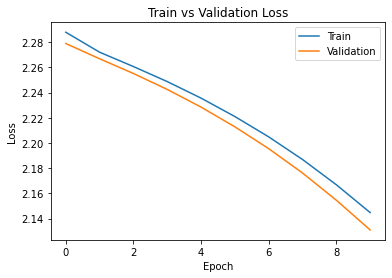

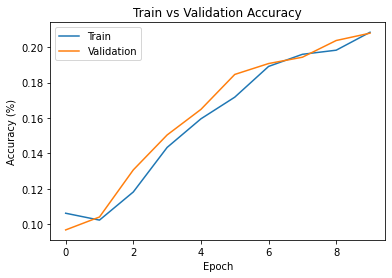

In [ ]:
train(EPOCHS = 10,BATCH = 32,LEARNING_RATE =1e-3)

**hyperparameters set 4**

In [ ]:
class ConvNet_FM_2(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 14, 4), objax.functional.relu]) 
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(14, 28, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(28, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # size=2, strides=2,
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

In [ ]:
model = ConvNet_FM_2()

Epoch 0001  Training Loss 2.25 Validation Loss 2.19 Training Accuracy 13.75 Validation Accuracy 19.70
Epoch 0002  Training Loss 2.06 Validation Loss 1.93 Training Accuracy 25.99 Validation Accuracy 37.14
Epoch 0003  Training Loss 1.78 Validation Loss 1.59 Training Accuracy 43.87 Validation Accuracy 50.54
Epoch 0004  Training Loss 1.43 Validation Loss 1.27 Training Accuracy 55.22 Validation Accuracy 56.89
Epoch 0005  Training Loss 1.20 Validation Loss 1.11 Training Accuracy 62.04 Validation Accuracy 63.14
Epoch 0006  Training Loss 1.08 Validation Loss 1.02 Training Accuracy 66.22 Validation Accuracy 64.87
Epoch 0007  Training Loss 1.00 Validation Loss 0.98 Training Accuracy 68.53 Validation Accuracy 63.09
Epoch 0008  Training Loss 0.95 Validation Loss 0.93 Training Accuracy 70.58 Validation Accuracy 67.37
Epoch 0009  Training Loss 0.92 Validation Loss 0.88 Training Accuracy 71.65 Validation Accuracy 70.96
Epoch 0010  Training Loss 0.89 Validation Loss 0.88 Training Accuracy 72.54 Valida

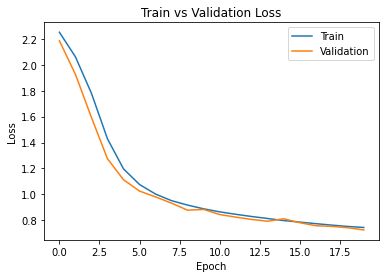

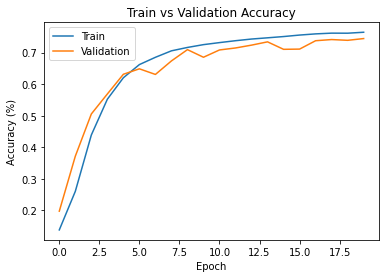

In [ ]:
train(EPOCHS = 20,BATCH = 32,LEARNING_RATE =5e-3)

**hyperparameters set 5**

In [ ]:
model = ConvNet_FM_2()

Epoch 0001  Training Loss 2.23 Validation Loss 2.15 Training Accuracy 14.00 Validation Accuracy 22.60
Epoch 0002  Training Loss 2.02 Validation Loss 1.89 Training Accuracy 27.93 Validation Accuracy 37.23
Epoch 0003  Training Loss 1.80 Validation Loss 1.67 Training Accuracy 42.02 Validation Accuracy 46.53
Epoch 0004  Training Loss 1.53 Validation Loss 1.38 Training Accuracy 51.22 Validation Accuracy 53.84
Epoch 0005  Training Loss 1.29 Validation Loss 1.18 Training Accuracy 59.48 Validation Accuracy 60.01
Epoch 0006  Training Loss 1.13 Validation Loss 1.06 Training Accuracy 64.33 Validation Accuracy 65.13
Epoch 0007  Training Loss 1.04 Validation Loss 0.99 Training Accuracy 67.08 Validation Accuracy 67.16
Epoch 0008  Training Loss 0.99 Validation Loss 0.96 Training Accuracy 68.58 Validation Accuracy 66.29
Epoch 0009  Training Loss 0.96 Validation Loss 0.94 Training Accuracy 69.63 Validation Accuracy 66.19
Epoch 0010  Training Loss 0.93 Validation Loss 0.92 Training Accuracy 70.49 Valida

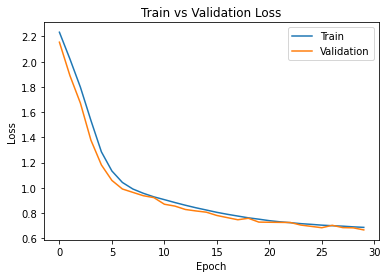

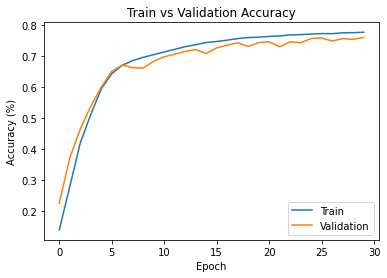

In [ ]:
train(EPOCHS = 30,BATCH = 32,LEARNING_RATE =5e-3)

The final model: 
ConvNet_FM_2(),EPOCHS = 30,BATCH = 32,LEARNING_RATE =5e-3

The best validation accuracy: 76.03% at epoch 30th

In [ ]:
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Final Test accuracy = ',test_acc*100,'%')

Final Test accuracy =  74.87142857142857 %


## **Problem 4. Open-Ended Exploration**

See the handout for instructions.

**Choose Question 4**. Build the following experienment on top of Problem 2 (CIFAR10 dataset ).

The following experienment will use the **VGG19** pretrained model.

### **VGG19**

In [ ]:
from keras.applications import VGG19
# from keras.applications.vgg19 import preprocess_input

In [ ]:
vgg19_model = VGG19(include_top=False,weights='imagenet',input_shape = (32,32,3))

The pretrained VGG19 model is a convolutional neural network that consists of 19 layers:  16 concolution layers and 3 fully connected layers. It also has 5 pooling layers. 

The input size is specified to (32,32,3) to fit the CIFAR10 dataset. Its **architecture** is shown below. 





In [ ]:
print(vgg19_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

**Use the pretrained model to extract features.**

In [ ]:
X_train.transpose(0,2,3,1).shape

(48000, 32, 32, 3)

In [ ]:
X_train_features = vgg19_model.predict(np.array(X_train.transpose(0,2,3,1)))

In [ ]:
# X_train_features = vgg19_model.predict(np.array(X_train.transpose(0,2,3,1)))
X_val_features = vgg19_model.predict(np.array(X_valid.transpose(0,2,3,1)))
X_test_features = vgg19_model.predict(np.array(X_test.transpose(0,2,3,1)))

In [ ]:
X_train = np.reshape(X_train_features, (48000, 1*1*512))
X_valid = np.reshape(X_val_features, (6000, 1*1*512))
X_test = np.reshape(X_test_features, (6000, 1*1*512))



Considering:

1.   The size of output featuers is 1x1x512 
2.   CIFAR10 dataset has 100 classes

, so we need to use **linear layers** which can help in maping the output features to one of the output classes

In [ ]:
class f_vgg(objax.Module):
  def __init__(self, number_of_classes = 10):
    self.linear_1 = objax.nn.Linear(512, number_of_classes)
    
  def __call__(self, x):
    x = self.linear_1(x)
    return x

**Model.1**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 2.20 Validation Loss 2.08 Training Accuracy 19.38 Validation Accuracy 26.08
Epoch 0002  Training Loss 1.99 Validation Loss 1.94 Training Accuracy 32.06 Validation Accuracy 34.12
Epoch 0003  Training Loss 1.88 Validation Loss 1.85 Training Accuracy 36.92 Validation Accuracy 36.98
Epoch 0004  Training Loss 1.81 Validation Loss 1.79 Training Accuracy 39.61 Validation Accuracy 39.50
Epoch 0005  Training Loss 1.76 Validation Loss 1.75 Training Accuracy 41.25 Validation Accuracy 40.70
Epoch 0006  Training Loss 1.72 Validation Loss 1.71 Training Accuracy 42.58 Validation Accuracy 41.93
Epoch 0007  Training Loss 1.69 Validation Loss 1.69 Training Accuracy 43.58 Validation Accuracy 42.72
Epoch 0008  Training Loss 1.66 Validation Loss 1.66 Training Accuracy 44.35 Validation Accuracy 43.12
Epoch 0009  Training Loss 1.64 Validation Loss 1.64 Training Accuracy 44.99 Validation Accuracy 44.18
Epoch 0010  Training Loss 1.62 Validation Loss 1.63 Training Accuracy 45.58 Valida

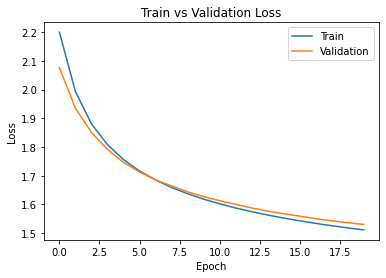

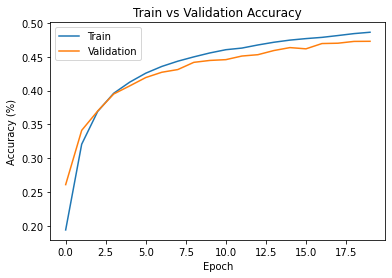

In [ ]:
train() # before tunning

In [ ]:
**Model.2**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 2.20 Validation Loss 2.05 Training Accuracy 20.72 Validation Accuracy 28.77
Epoch 0002  Training Loss 1.97 Validation Loss 1.90 Training Accuracy 33.90 Validation Accuracy 36.20
Epoch 0003  Training Loss 1.85 Validation Loss 1.82 Training Accuracy 38.55 Validation Accuracy 38.42
Epoch 0004  Training Loss 1.78 Validation Loss 1.76 Training Accuracy 40.69 Validation Accuracy 40.70
Epoch 0005  Training Loss 1.73 Validation Loss 1.72 Training Accuracy 42.18 Validation Accuracy 42.00
Epoch 0006  Training Loss 1.69 Validation Loss 1.69 Training Accuracy 43.36 Validation Accuracy 42.95
Epoch 0007  Training Loss 1.66 Validation Loss 1.66 Training Accuracy 44.29 Validation Accuracy 43.43
Epoch 0008  Training Loss 1.64 Validation Loss 1.64 Training Accuracy 44.83 Validation Accuracy 43.77
Epoch 0009  Training Loss 1.62 Validation Loss 1.62 Training Accuracy 45.48 Validation Accuracy 44.40
Epoch 0010  Training Loss 1.60 Validation Loss 1.61 Training Accuracy 46.11 Valida

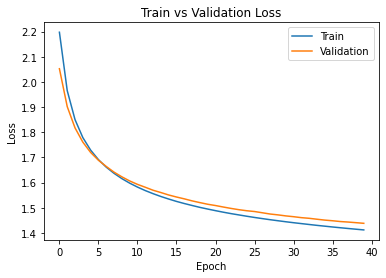

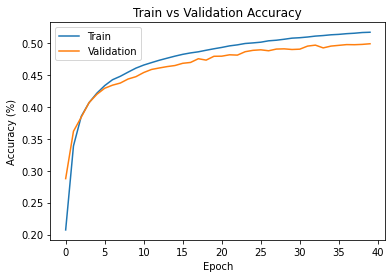

In [ ]:
train(EPOCHS = 40,BATCH = 32,LEARNING_RATE = 1e-3) #larger learning rate

**Model.3**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 2.09 Validation Loss 1.92 Training Accuracy 26.42 Validation Accuracy 34.70
Epoch 0002  Training Loss 1.83 Validation Loss 1.78 Training Accuracy 39.64 Validation Accuracy 40.30
Epoch 0003  Training Loss 1.72 Validation Loss 1.70 Training Accuracy 42.87 Validation Accuracy 42.97
Epoch 0004  Training Loss 1.66 Validation Loss 1.65 Training Accuracy 44.76 Validation Accuracy 44.20
Epoch 0005  Training Loss 1.61 Validation Loss 1.61 Training Accuracy 45.99 Validation Accuracy 45.50
Epoch 0006  Training Loss 1.58 Validation Loss 1.59 Training Accuracy 46.99 Validation Accuracy 46.17
Epoch 0007  Training Loss 1.55 Validation Loss 1.56 Training Accuracy 47.68 Validation Accuracy 46.75
Epoch 0008  Training Loss 1.53 Validation Loss 1.55 Training Accuracy 48.27 Validation Accuracy 47.35
Epoch 0009  Training Loss 1.52 Validation Loss 1.53 Training Accuracy 48.90 Validation Accuracy 47.63
Epoch 0010  Training Loss 1.50 Validation Loss 1.52 Training Accuracy 49.22 Valida

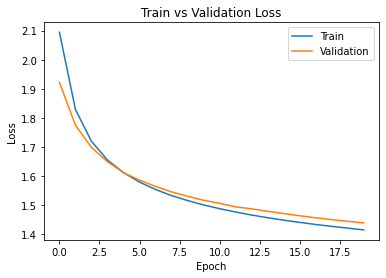

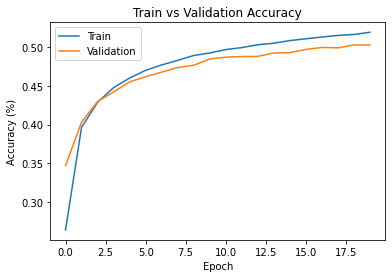

In [ ]:
train(EPOCHS = 20,BATCH = 32,LEARNING_RATE = 2e-3)

**Model.4**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 2.09 Validation Loss 1.91 Training Accuracy 27.34 Validation Accuracy 35.53
Epoch 0002  Training Loss 1.83 Validation Loss 1.77 Training Accuracy 39.73 Validation Accuracy 40.07
Epoch 0003  Training Loss 1.72 Validation Loss 1.69 Training Accuracy 42.72 Validation Accuracy 42.23
Epoch 0004  Training Loss 1.66 Validation Loss 1.65 Training Accuracy 44.61 Validation Accuracy 43.93
Epoch 0005  Training Loss 1.61 Validation Loss 1.61 Training Accuracy 45.87 Validation Accuracy 44.90
Epoch 0006  Training Loss 1.58 Validation Loss 1.58 Training Accuracy 46.74 Validation Accuracy 45.68
Epoch 0007  Training Loss 1.56 Validation Loss 1.56 Training Accuracy 47.55 Validation Accuracy 46.35
Epoch 0008  Training Loss 1.53 Validation Loss 1.55 Training Accuracy 48.30 Validation Accuracy 46.75
Epoch 0009  Training Loss 1.52 Validation Loss 1.53 Training Accuracy 48.62 Validation Accuracy 47.35
Epoch 0010  Training Loss 1.50 Validation Loss 1.52 Training Accuracy 49.22 Valida

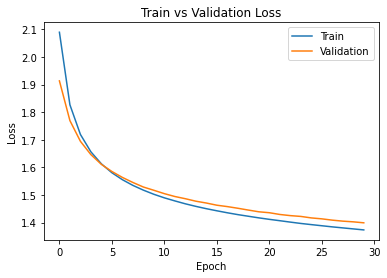

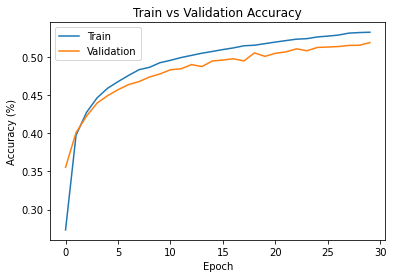

In [ ]:
train(EPOCHS = 30,BATCH = 32,LEARNING_RATE = 2e-3)

**Model.5**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 1.80 Validation Loss 1.62 Training Accuracy 40.40 Validation Accuracy 44.77
Epoch 0002  Training Loss 1.56 Validation Loss 1.53 Training Accuracy 48.57 Validation Accuracy 46.85
Epoch 0003  Training Loss 1.49 Validation Loss 1.48 Training Accuracy 50.68 Validation Accuracy 48.93
Epoch 0004  Training Loss 1.45 Validation Loss 1.46 Training Accuracy 52.02 Validation Accuracy 49.22
Epoch 0005  Training Loss 1.42 Validation Loss 1.43 Training Accuracy 52.72 Validation Accuracy 50.42
Epoch 0006  Training Loss 1.40 Validation Loss 1.41 Training Accuracy 53.28 Validation Accuracy 50.98
Epoch 0007  Training Loss 1.38 Validation Loss 1.40 Training Accuracy 53.97 Validation Accuracy 51.07
Epoch 0008  Training Loss 1.36 Validation Loss 1.38 Training Accuracy 54.51 Validation Accuracy 51.57
Epoch 0009  Training Loss 1.35 Validation Loss 1.38 Training Accuracy 54.89 Validation Accuracy 51.77
Epoch 0010  Training Loss 1.34 Validation Loss 1.36 Training Accuracy 55.19 Valida

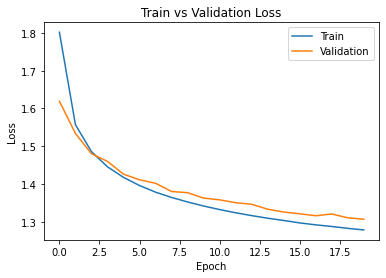

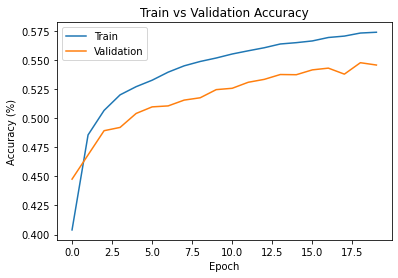

In [ ]:
train(EPOCHS = 20,BATCH = 32,LEARNING_RATE = 9e-3)

**Model.6**

In [ ]:
model = f_vgg()

Epoch 0001  Training Loss 1.91 Validation Loss 1.73 Training Accuracy 35.35 Validation Accuracy 40.47
Epoch 0002  Training Loss 1.65 Validation Loss 1.61 Training Accuracy 45.17 Validation Accuracy 44.47
Epoch 0003  Training Loss 1.57 Validation Loss 1.56 Training Accuracy 47.62 Validation Accuracy 46.28
Epoch 0004  Training Loss 1.52 Validation Loss 1.52 Training Accuracy 49.00 Validation Accuracy 47.35
Epoch 0005  Training Loss 1.48 Validation Loss 1.49 Training Accuracy 50.07 Validation Accuracy 48.22
Epoch 0006  Training Loss 1.46 Validation Loss 1.47 Training Accuracy 50.91 Validation Accuracy 49.05
Epoch 0007  Training Loss 1.44 Validation Loss 1.46 Training Accuracy 51.45 Validation Accuracy 49.42
Epoch 0008  Training Loss 1.42 Validation Loss 1.44 Training Accuracy 51.90 Validation Accuracy 49.82
Epoch 0009  Training Loss 1.41 Validation Loss 1.43 Training Accuracy 52.38 Validation Accuracy 50.60
Epoch 0010  Training Loss 1.40 Validation Loss 1.42 Training Accuracy 52.87 Valida

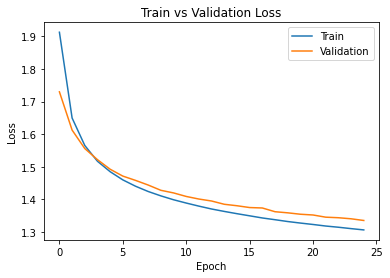

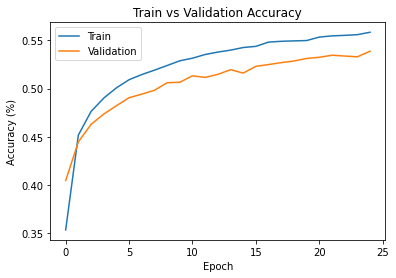

In [ ]:
train(EPOCHS = 25,BATCH = 32,LEARNING_RATE = 5e-3) #large learning rate

In [ ]:
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Final Test accuracy = ',test_acc*100,'%')

Final Test accuracy =  53.333333333333336 %
